#Predicting Flight Delays to Optimize Airport Staffing Levels

Authors: Matt Pribadi, Jacquie Nesbitt, Karl Eirich, Kasha Muzila

##Table of Contents
 1. [Business Case](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262179)
 2. [Exploratory Data Analysis](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262182)
 3. [Preprocessing and Feature Engineering](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262238)
 4. [Algorithm Theory](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262246)
 5. [Algorithm Implementation](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262251)
 6. [Conclusion](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262252)
 7. [Course Concepts](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324262253)
 8. [References](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324255597/command/1898361324255642)

d
#1. Business Case

Delayed flights are the bane of ground handling companies' existence because they lead to scheduling issues and huge economic losses. As a result, there is a demand for being able to predict flight delays to optimize operations [[1]](https://www.trefis.com/stock/dal/articles/375013/what-is-the-impact-of-flight-delays/2016-08-31). Our product would directly help all ground handling companies, specifically general managers, who are responsible for staffing airport and ramp roles. Ground handling companies encounter two issues that prevent profitability: seasonality (such as slower seasons) and inefficient staffing. A prediction model would allow general managers to be more strategic and reduce high staffing costs.

Therefore, the question for our analysis is the following: 
> *Will this model help ground handling companies be able to accurately predict flight delays of a scheduled flight two hours before departure, to optimize staffing levels?*

For our business case, we will be measuring the effectiveness of our model by calculating the F_0.5 score. The F_0.5 score allows us to put more importance on reducing false positives for imbalanced datasets. Increased importance on false positives is necessary because in our business case a false positive has the highest cost. If a flight was falsely predicted to be delayed through our model, the ground handling company would reduce staffing levels during the delay period. This is the worse case scenario because the reduced staffing levels could potential result in an on-time flight to become delayed which would negatively affect airline metrics, the ground handling company's reputation, overwhelm employees, and potentially increase accidents due to time constraints [[2]](https://www.researchgate.net/publication/334002767_Assessing_the_effects_of_flight_delays_distance_number_of_passengers_and_seasonality_on_revenue). While, a false negative would make the ground handling company have more staff than required, which would result in increased operating expenses for the company, the current status quo. 

The data for our product comes from multiple datasets, including data for flight departures and hourly weather for various weather stations. The flights dataset is a subset of the passenger flights' on-time performance data taken from **TranStats** [[3]](https://www.transportation.gov/), which is available from the **U.S. Department of Transportation**. The weather dataset consists of weather information corresponding to stations which include airports. This dataset has been pre-downloaded from the **National Oceanic and Atmospheric Administration repository** [[4]](https://repository.library.noaa.gov/) to S3 in the form of parquet files. Both datasets span from the years 2015 to 2019.

#2. Exploratory Data Analysis

##2.1 Airlines Dataset

For the main dataset, we are using the on-time performance data of passenger flights from the years 2015 to 2019. This dataset was acquired using TranStats from the U.S. Department of Transportation and contains a total of 109 different variables. These variables contain detailed information about flights in the United States, including, but not limited to the date, flight number, departure and arrival times, route information, delays, and diversions. To begin understanding this dataset, we’re going to select 6 months of data to visualize. After, we removed the columns that have more than 50% null, which then we divided into continuous and categorical lists for further investigation.

###2.1.1 Continuous Variables

For our continuous variables, we created a correlation matrix to help us understand and identify which continuous variables from the flight dataset would be useful for our model. However, even though we see that these variables are correlated with our target metric, they would only be available after the two hour prediction deadline. As a result, we did not include any continuous variables from our flight dataset in our model.

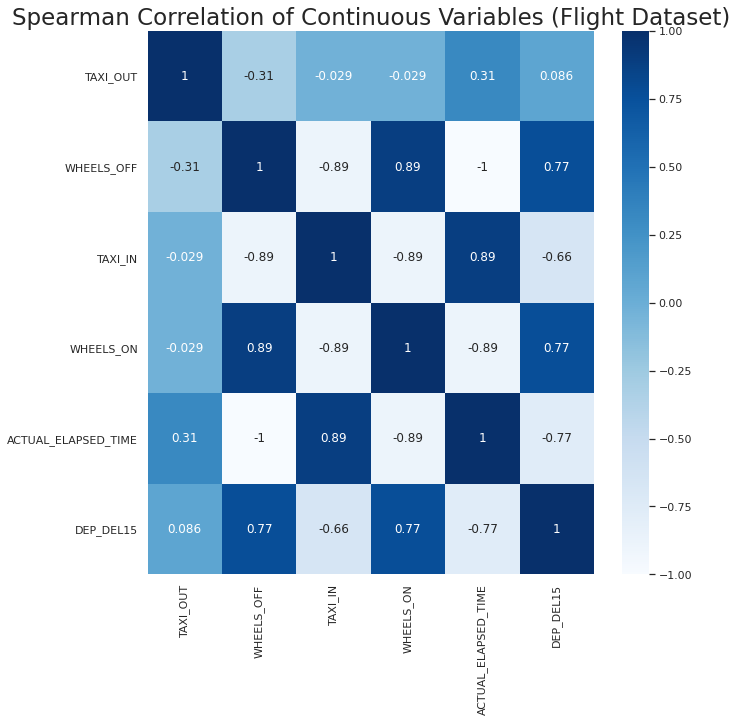

Out[61]: <module 'matplotlib.pyplot' from '/databricks/python/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [0]:
def FlightCorrelation(path):
    final_df_airlines = spark.read.parquet(f"{path}")

    cont_df = final_df_airlines.select('TAXI_OUT', 'WHEELS_OFF', 'TAXI_IN','WHEELS_ON', 'ACTUAL_ELAPSED_TIME', 'DEP_DEL15')

    assembler = VectorAssembler(inputCols=cont_df.columns, outputCol="features",handleInvalid='keep')
    df = assembler.transform(cont_df).select("features")

    # correlation will be in Dense Matrix
    correlation = Correlation.corr(df,"features","spearman").collect()[0][0]

    # To convert Dense Matrix into DataFrame
    rows = correlation.toArray().tolist()
    df = spark.createDataFrame(rows,cont_df.columns)

    airlinestest = df.toPandas()
    dftest = airlinestest.corr(method='spearman')
    sns.set(rc={'figure.figsize':(10,10)})
    sns.heatmap(dftest, cmap="Blues", annot=True)
    plt.title("Spearman Correlation of Continuous Variables (Flight Dataset)", fontsize = 23)
    plt.show()
    return plt
FlightCorrelation('/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/')

###2.1.2 Categorical Variables

To understand the relationship between the flight categorical variables and the target metric, we build 100% bar charts to identify variations between the different options in our categorical variables. From here, we identified that several variables, specifically the carrier, day of week, month, and departure block (which we later modified into time of day) had variation to indicate a relationship to our target variable.

Out[63]:

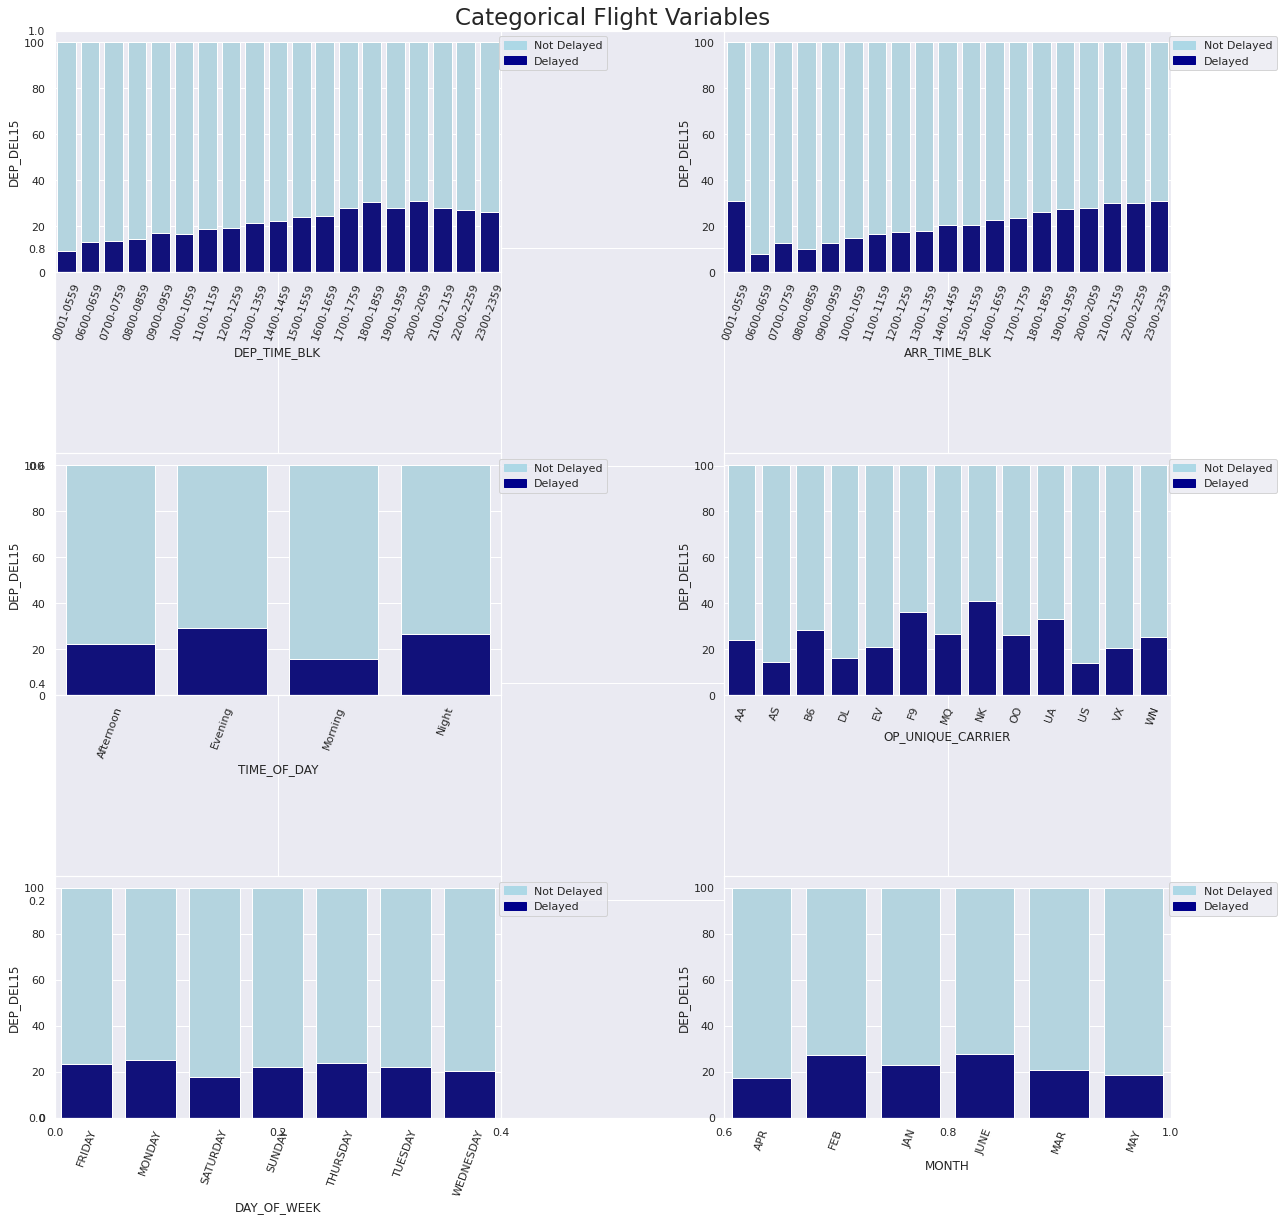

<Figure size 1440x1440 with 7 Axes>

In [0]:
def cat_EDA(df):
    '''Create graphs for selected categorical columns
    '''
    
    fields_plot = ['DEP_TIME_BLK','ARR_TIME_BLK', 'TIME_OF_DAY', 'OP_UNIQUE_CARRIER', 'DAY_OF_WEEK', 'MONTH']

    p_final_df_airlines = df.toPandas()

    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=.75, wspace=0.5)
    plt.title("Categorical Flight Variables", fontsize = 23)
    p=1
    for fld in fields_plot:
        ax = fig.add_subplot(3, 2, p)
        grouped = p_final_df_airlines.groupby(fld)['DEP_DEL15'].count().reset_index()
        delayed = p_final_df_airlines[p_final_df_airlines.DEP_DEL15 == 1].groupby(fld)['DEP_DEL15'].count().reset_index()
        delayed['DEP_DEL15'] = [i / j * 100 for i,j in zip(delayed['DEP_DEL15'], grouped['DEP_DEL15'])]
        grouped['DEP_DEL15'] = [i / j * 100 for i,j in zip(grouped['DEP_DEL15'], grouped['DEP_DEL15'])]
        bar1 = sns.barplot(x=fld,  y="DEP_DEL15", data=grouped, color='lightblue')
        bar2 = sns.barplot(x=fld, y="DEP_DEL15", data=delayed, color='darkblue')
        plt.xticks(rotation=70)
        p+=1
        top_bar = mpatches.Patch(color='lightblue', label='Not Delayed')
        bottom_bar = mpatches.Patch(color='darkblue', label='Delayed')
        plt.legend(handles=[top_bar, bottom_bar], loc='upper right', bbox_to_anchor=(1.25, 1.0))
    return fig
flight_df = FlightPreprocessing('/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/')
cat_EDA(flight_df)

###2.1.3 Target Variable

For our target variable, we chose `DEP_DEL15` which is a binary indicator variable that is 1 when a flight is delayed 15 mins or more and 0 if a flight is on-time or delayed less than 15 mins. After reviewing the distribution of this variable, we identified that most flights are either on-time or less than 15 mins delayed which means that we need to be mindful when choosing our metric and make sure to attempt rebalancing techniques.

Out[36]:

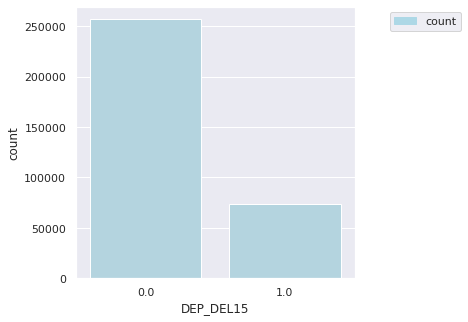

<Figure size 360x360 with 1 Axes>

In [0]:
def SingleEDA(path, field):
    '''Create graphsfor single variable
    '''
    final_df_airlines = spark.read.parquet(f"{path}")
    p_final_df_airlines = final_df_airlines.toPandas()
    fig = plt.figure(figsize=(5,5))
    ax = sns.countplot(x=field, data=p_final_df_airlines, color='lightblue')
    top_bar = mpatches.Patch(color='lightblue', label='count')
    plt.legend(handles=[top_bar], loc='upper right', bbox_to_anchor=(1.4, 1.0))
    return fig
SingleEDA('/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/', 'DEP_DEL15')

###2.1.4 Cancellations

Lastly, we needed to decide how to manage flights that were canceled. We noticed that there are very few canceled flights, additionally according to our business case there has to be a baseline of staff available. Consequently, we decided to drop canceled flights from this analysis.

Out[57]:

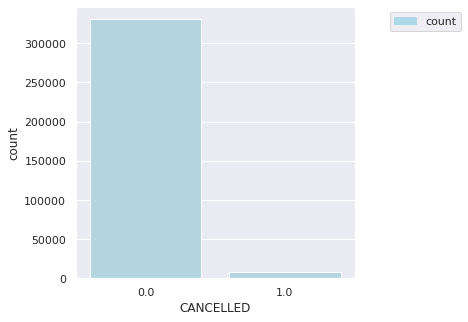

<Figure size 360x360 with 1 Axes>

In [0]:
SingleEDA('/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/', 'CANCELLED')

##2.2 Weather Dataset

####2.2.1 Understanding the Data

The main dataset used for weather data is from the National Oceanic and Atmospheric Administration (NOAA)'s Quality Controlled Local Climatological Data (QCLCD). This dataset contains information from major weather stations. This information includes, but is not limited to, a daily account of maximum and minimum temperatures, hourly precipitation amounts, wind direction,  wind speed, and summarized 3-hourly weather observations. The monthly summaries include temperature extremes, average temperature, temperature deviations from baseline, dew points, average station pressure, ceiling, visibility, weather type, wet bulb temperature, relative humidity, degree days (heating and cooling), daily precipitation, average wind speed, fastest wind speed/direction, sky cover, and occurrences of sunshine, snowfall and snow depth. Within the dataset is a station table showing a history of changes in the instrumentation, which can be used to further filter the dataset.

md

####2.2.2 Initial Exploration

When exploring the data we noticed that there are several weather characteristics grouped into a single column. For example, a column referring to rain contains the amount of rain that occured during that time and a qualitative metric that indicates if this number is of high quality or erroneous. In addition to these highly compacted columns, we also have some columns that are sparsely populated due to missing data or only extreme weather information is collected in that column. After consulting the data dictionary, we learned that there are multiple report types (`REPORT_TYPE`) in the dataset. For example, a FM-16 report refers to a "special weather report" this report only occurs if there's a major weather shift before the next hourly scheduled weather report is taken. This hourly weather report is known as FM-15. Knowledge about these reports helped us quickly filter out unnecessary weather rows for the join.

In [0]:
from pyspark.sql.functions import col

df_weather = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*")
display(df_weather)

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,AW1,GA1,GA2,GA3,GA4,GE1,GF1,KA1,KA2,MA1,MD1,MW1,MW2,OC1,OD1,OD2,REM,EQD,AW2,AX4,GD1,AW5,GN1,AJ1,AW3,MK1,KA4,GG3,AN1,RH1,AU5,HL1,OB1,AT8,AW7,AZ1,CH1,RH3,GK1,IB1,AX1,CT1,AK1,CN2,OE1,MW5,AO1,KA3,AA3,CR1,CF2,KB2,GM1,AT5,AY2,MW6,MG1,AH6,AU2,GD2,AW4,MF1,AA1,AH2,AH3,OE3,AT6,AL2,AL3,AX5,IB2,AI3,CV3,WA1,GH1,KF1,CU2,CT3,SA1,AU1,KD2,AI5,GO1,GD3,CG3,AI1,AL1,AW6,MW4,AX6,CV1,ME1,KC2,CN1,UA1,GD5,UG2,AT3,AT4,GJ1,MV1,GA5,CT2,CG2,ED1,AE1,CO1,KE1,KB1,AI4,MW3,KG2,AA2,AX2,AY1,RH2,OE2,CU3,MH1,AM1,AU4,GA6,KG1,AU3,AT7,KD1,GL1,IA1,GG2,OD3,UG1,CB1,AI6,CI1,CV2,AZ2,AD1,AH1,WD1,AA4,KC1,IA2,CF3,AI2,AT1,GD4,AX3,AH4,KB3,CU1,CN4,AT2,CG1,CF1,GG1,MV2,CW1,GG4,AB1,AH5,CN3
7650099999,2016-01-01T00:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-12,99999,V020,"190,1,N,0015,1","99999,9,9,N","007000,1,9,9","+0101,1","+0090,1","10255,1",,"99,9,+02250,1,99,9",,,,"9,AGL ,+99999,+99999","08,99,1,99,9,99,9,02250,1,99,9,99,9",,,"99999,9,10216,1","8,1,004,1,+999,9","61,1",,,"3,99,0026,1,999",,SYN09807650 04857 81903 10101 20090 30216 40255 58004 69901 761// 333 4/000 69907 90710 91105 555 69905=,,,,,,,"9999,1,9,999999,9,9",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"03,0000,2,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"06,0000,2,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T00:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"190,1,N,0015,1","22000,1,9,N","009000,1,9,9","+0100,1","+0090,1","99999,9","61,1",,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T00:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"250,1,N,0010,1","99999,9,9,N","008000,1,9,9","+9999,9","+9999,9","99999,9",,,,,,,,,,"10250,1,99999,9",,,,,,,MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025=,Q019 2ATOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-12,99999,V020,"999,9,C,0000,1","99999,9,9,N","004900,1,9,9","+0099,1","+0094,1","10251,1",,"99,9,+02250,1,99,9",,,,"9,AGL ,+99999,+99999","08,99,1,99,9,99,9,02250,1,99,9,99,9",,,"99999,9,10212,1","8,1,006,1,+999,9","10,1",,,"3,99,0015,1,999",,SYN07607650 24849 80000 10099 20094 30212 40251 58006 710// 333 69925 90710 91103=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"01,0002,3,1",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","007000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T01:30:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-15,99999,V020,"999,9,C,0000,1","22000,1,9,N","009000,1,9,9","+0100,1","+0090,1","99999,9",,,,,,,"00,99,1,99,9,99,9,99999,9,99,9,99,9",,,"10250,1,99999,9",,,,,,,MET053METAR LFML 010130Z AUTO 00000KT 9000 NSC 10/09 Q1025=,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7650099999,2016-01-01T02:00:00.000+0000,4,43.435555,5.213611,22.55,"PROVENCE, FR",FM-12,99999,V020,"999,9,C,0000,1","99999,9,9,N","011000,1,9,9","+0100,1","+0088,1","10254,1",,"99,9,+01750,1,99,9",,,,"9,AGL ,+99999,+99999","08,99,1,99,9,99,9,01750,1,99,9,99,9",,,"99

In [0]:
print(f'Base Weather Table size: ')
df_weather.count()

Base Weather Table size: 
Out[7]: 630904436

####2.2.3 Continuious Variables

Next, we pulled out the continuious features from the weather data and created a correlation heatmap to identify variables that have high correlation. We see that many of them have a high correlation because, according to the data dictionary, these features are derivatives of each other. An interesting insight derived from the data is when sorting the features by their correlation to our target variable we see the features representing the same weather phenomena receiving similar correlation scores. The correlation of weather phenomena is a good indicator of whether we should focus further effort on engineering features around the weather phenomena or allocate time elsewhere.

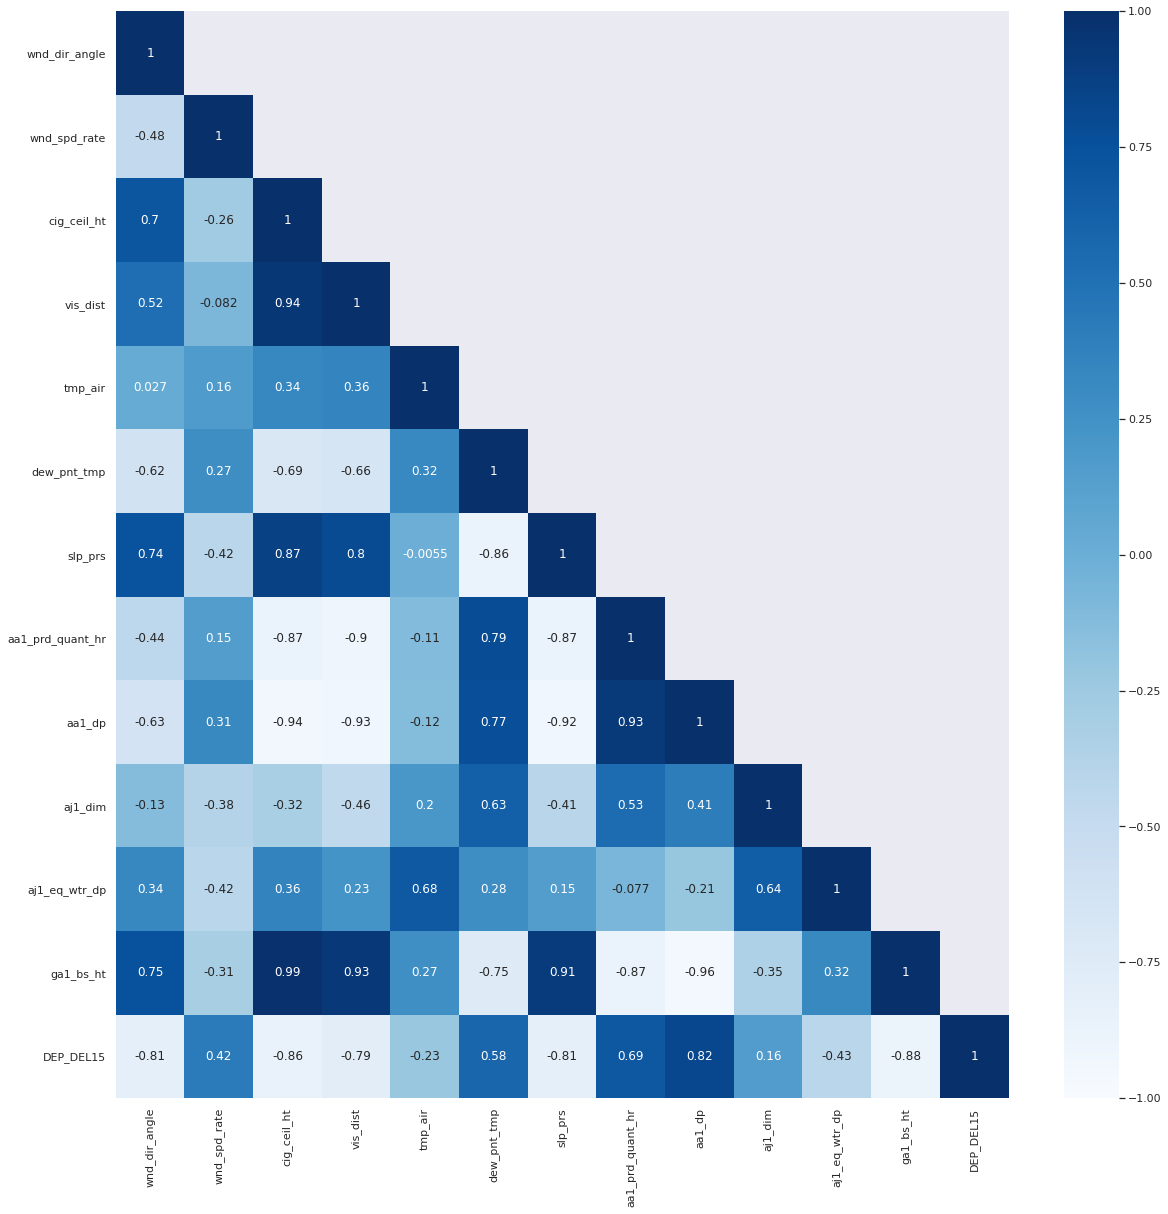

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

def feature_heat(og_df,features,is_delay=False):
    cont_df = og_df.select(features)
    assembler = VectorAssembler(inputCols=cont_df.columns, outputCol="features",handleInvalid='keep')
    df = assembler.transform(cont_df).select("features")
    correlation = Correlation.corr(df,"features","spearman").collect()[0][0]
    rows = correlation.toArray().tolist()
    df = spark.createDataFrame(rows,cont_df.columns)
    airlinestest = df.toPandas()
    dftest = airlinestest.corr(method='spearman')
    sns.set(rc={'figure.figsize':(20,20)})
    if is_delay:
        sns.heatmap(dftest[['DEP_DEL15']].sort_values(by=['DEP_DEL15'],ascending=False), vmin = -1, vmax = +1, cmap = 'Blues', annot=True)
    else:
        mask = np.triu(dftest, k=1)
        sns.heatmap(dftest, vmin = -1, vmax = +1,mask=mask,cmap = 'Blues', annot=True)
    plt.show()
    
heat_feat = [
             'wnd_dir_angle', 
             'wnd_spd_rate', 
             'cig_ceil_ht', 
             'vis_dist', 
             'tmp_air', 
             'dew_pnt_tmp',
             'slp_prs', 
             'aa1_prd_quant_hr', 
             'aa1_dp', 
             'aj1_dim', 
             'aj1_eq_wtr_dp', 
             'ga1_bs_ht', 
             'DEP_DEL15'
            ]

df_6m = df_6m.withColumn("wnd_dir_angle",df_6m.wnd_dir_angle.cast(IntegerType()))

feature_heat(df_6m, heat_feat)

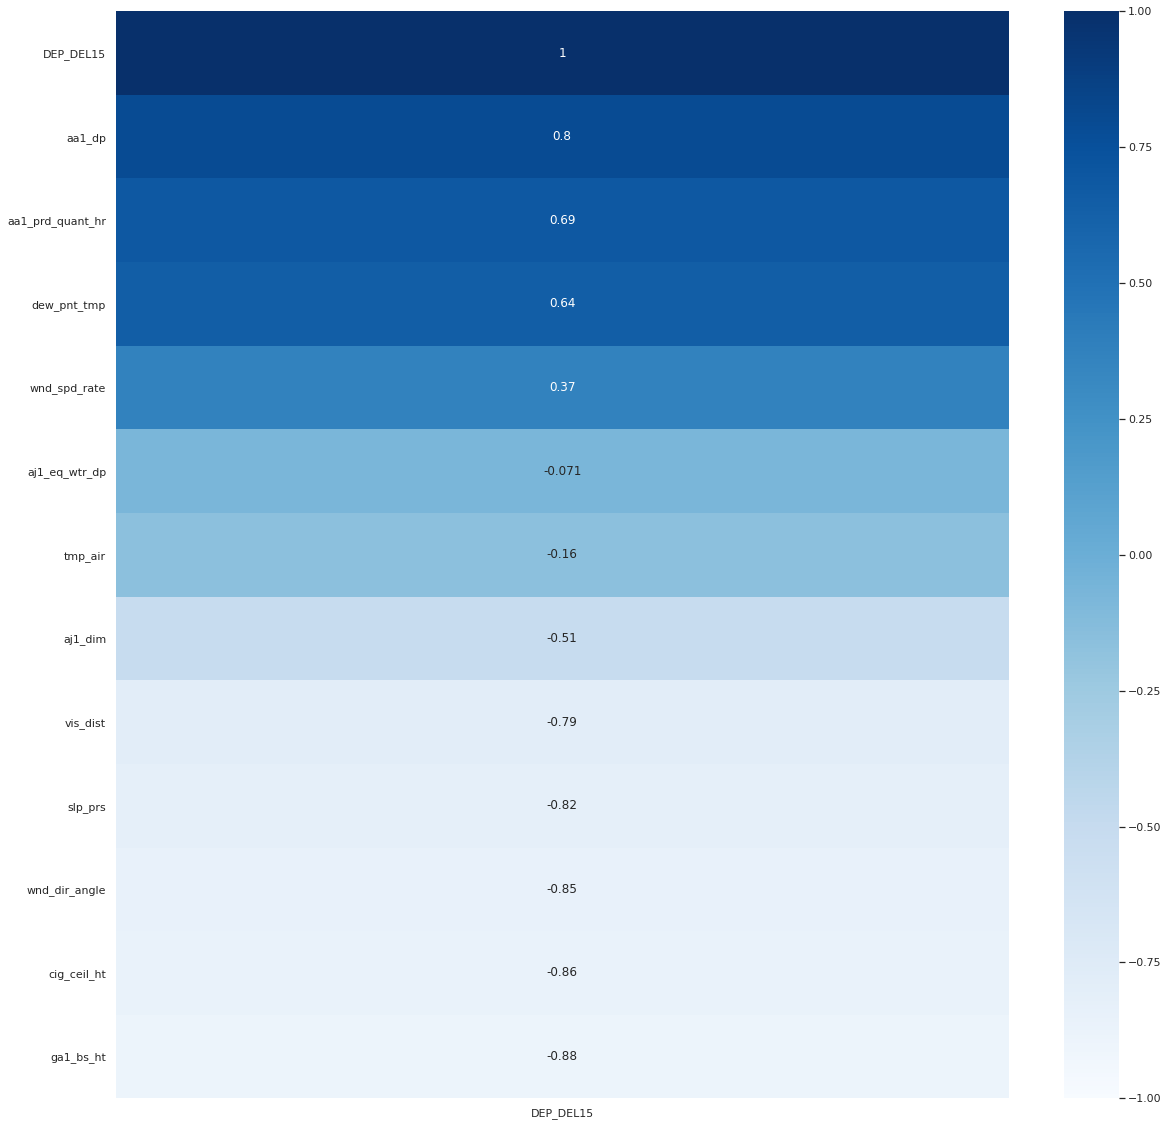

In [0]:
feature_heat(df_6m, heat_feat, True)

####2.2.4 Categorical Variables

The graphs below demonstrate the relationship between selected categorical variables have with our target variable. We noticed when a cumulonimbus cloud (09) is present there are more delays. With this information, we were able to identify which variables we would like to keep in our model.

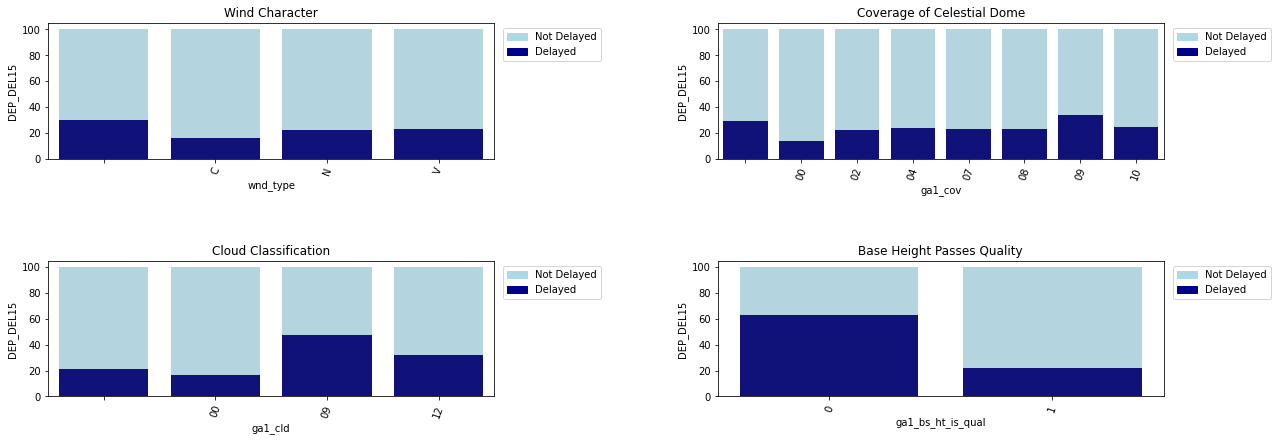

In [0]:
from pyspark.sql.types import IntegerType,BooleanType,DateType,StringType,TimestampType
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

blob_container = "tm30container" # The name of your container created in https://portal.azure.com
storage_account = "w261tm30" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261tm30" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "tm30key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

def feature_plot(df,features,titles=[],is_ttl=False):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=.75, wspace=0.5)
    p=0
    for loc,ftr in enumerate(features):
        p+=1
        ax = fig.add_subplot(5,2,p)
        grouped = df.groupby(ftr)['DEP_DEL15'].count().reset_index()
        delayed = df[df.DEP_DEL15 == 1].groupby(ftr)['DEP_DEL15'].count().reset_index()
        delayed['DEP_DEL15'] = [i / j * 100 for i,j in zip(delayed['DEP_DEL15'], grouped['DEP_DEL15'])]
        grouped['DEP_DEL15'] = [i / j * 100 for i,j in zip(grouped['DEP_DEL15'], grouped['DEP_DEL15'])]
        bar1 = sns.barplot(x=ftr,  y="DEP_DEL15", data=grouped, color='lightblue')
        bar2 = sns.barplot(x=ftr, y="DEP_DEL15", data=delayed, color='darkblue')
        plt.xticks(rotation=70)
        top_bar = mpatches.Patch(color='lightblue', label='Not Delayed')
        bottom_bar = mpatches.Patch(color='darkblue', label='Delayed')
        plt.legend(handles=[top_bar, bottom_bar], loc='upper right', bbox_to_anchor=(1.25, 1.0))
        if is_ttl:
            ax.set_title(titles[loc],fontsize='large')
    
field_titles = [
                'Wind Character',
                'Coverage of Celestial Dome',
                'Cloud Classification',
                'Base Height Passes Quality'
               ]

fields_plot = [
               'wnd_type', 
               'ga1_cov',
               'ga1_cld', 
               'ga1_bs_ht_is_qual'
              ]

pd_df_6m = (spark.read.parquet(f"{blob_url}/2022-03-24_data_chkpt_PQ_full")
         .filter(col('FLIGHT_UTC_DATE') < "2015-07-01T00:00:00.000")
         .toPandas()) 


feature_plot(pd_df_6m,fields_plot,field_titles,True)

#3. Preprocessing and Feature Engineering

##3.1 Airlines Dataset

###3.1.2 Selected Features

| Variable Name | Definition |
| ----| ----|
| UNIQUE_ID | A unique ID to help us identify distinct flights. |
| FLIGHT_UTC_DATE | Date and time of the flight’s scheduled departure in UTC time. |
| RANK | Each flight’s percent rank as ordered by FLIGHT_UTC_DATE ascending. (Created after joining flight and weather datasets.) |
| TIME_OF_DAY | Indicates morning, afternoon, evening or night depending on the flight's local departure time. |
| MONTH | Indicates January - December of when the flight departed. |
| DAY_OF_WEEK | Indicates Monday - Sunday of when the flight departed. |
| OP_UNIQUE_CARRIER | Indicates unique carrier name. Ex. AA for American Airlines |
| FLIGHT_ROUTE | Indicates specific flight route. Ex. ORD - IAH |
| DEP_DEL15 | Binary indicator indicating if a flight was delayed 15 minutes or more. |

###3.1.3 Feature Engineering

**UNIQUE_ID**

This field is not native to our flight dataset. For our use in identifying distinct flight observations, we created this variable by concatenating the unique carrier, the flight number, the flight date and local time. Once we created this field, we removed all true duplicates from our dataset.

**FLIGHT_UTC_DATE**

In order for us to join the flight dataset to the weather dataset, we created this field by creating the timestamp by formatting and combining the local date and time fields, then using the airport as a key to translate the local timestamp into a UTC timestamp.

**RANK**

After the join, we created this rank field by calculating each flight’s percent rank on ascending `FLIGHT_UTC_DATE` so that we would be able to create appropriate slices for our cross validation function.

**TIME_OF_DAY**

We noticed from our EDA that the flight scheduled departure block variable had considerable delay variation depending on the hour block in which it was scheduled to depart. To capture this, we engineered the time of day variable which broke the day into morning, afternoon, evening, night.

**FLIGHT_ROUTE**

We also created the flight route variable for each flight by concatenating the origin airport and destination airport.

**Missing Values**

We do not have any missing values in our flight dataset that would require imputation.

In [0]:
def FlightPreprocessing(path):
    '''Perform EDA and Preprocessing on flight data
    '''
    df_airlines = spark.read.parquet(f"{path}")
    df2 = df_airlines.select([(f.count(f.when(f.isnan(c) | f.col(c).isNull(), c))/f.count(f.lit(1))).alias(c)
                        for c in df_airlines.columns]).collect()

    #identify columns with more than 50% nulls
    remove_columns = [c for c in df_airlines.columns if df2[0].__getitem__(c) > .5]

    #remove all columns that have 50% or more nulls and or cannot be acquired 2 hours before departure
    remove_unncessary_columns = ['DEP_DELAY', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'WHEELS_OFF', 'FLIGHTS', 'OP_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'CANCELLED', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'TAXI_IN', 'ARR_DELAY_GROUP', 'ORIGIN_AIRPORT_SEQ_ID', 'DIVERTED', 'AIR_TIME', 'DISTANCE_GROUP', 'DISTANCE', 'DEST_AIRPORT_SEQ_ID',  'ORIGIN_CITY_MARKET_ID', 'FLIGHTS', 'ARR_DEL15', 'ARR_DEL_NEW','QUARTER','DIV_AIRPORT_LANDINGS', 'WHEELS_ON', 'ACTUAL_ELAPSED_TIME', 'YEAR', 'DAY_OF_MONTH', 'DEST_CITY_MARKET_ID', 'ORIGIN_AIRPORT_ID', 'ORIGIN_STATE_FIPS','ORIGIN_WAC', 'DEST_AIRPORT_ID', 'ORIGIN_AIRPORT_ID', 'ORIGIN_STATE_FIPS', 'DES_WAC', 'DEST_STATE_FIPS', 'DEST_STATE_NM','ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM','DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM','DEST_WAC', 'DEP_TIME']
    final_df_airlines = df_airlines.drop(*remove_columns).drop(*remove_unncessary_columns)

    #Create Time of Day Field
    final_df_airlines = final_df_airlines.withColumn('TIME_OF_DAY', f.when(final_df_airlines.CRS_DEP_TIME.between(500,1159), 'Morning')\
                                                                    .when(final_df_airlines.CRS_DEP_TIME.between(1200,1659), 'Afternoon')\
                                                                    .when(final_df_airlines.CRS_DEP_TIME.between(1700,2259), 'Evening')\
                                                                    .otherwise('Night'))


    #Convert Integers Into Strings and Format Date
    final_df_airlines = final_df_airlines.withColumn("OP_CARRIER_FL_NUM",f.col("OP_CARRIER_FL_NUM").cast(StringType())) \
                                         .withColumn("CRS_DEP_TIME",f.col("CRS_DEP_TIME").cast(StringType())) \
                                         .withColumn("FL_DATE", f.date_format("FL_DATE", "yyyy-dd-MM"))

    #Pad missing 0 and and convert into timestamp, create unique id to drop duplicates, convert columns from strings to integers
    final_df_airlines = final_df_airlines.withColumn('CRS_DEP_TIME', f.lpad(final_df_airlines.CRS_DEP_TIME,4, '0')) \
                                         .withColumn('DATE_TIME', f.concat(f.col('FL_DATE'),f.lit(" "),f.col('CRS_DEP_TIME'))) \
                                         .withColumn("DATE_TIME", f.to_timestamp("DATE_TIME", "yyyy-dd-MM HHmm")) \
                                         .withColumn('UNIQUE_ID', f.concat(f.col('OP_UNIQUE_CARRIER'),f.lit("-"),f.col('OP_CARRIER_FL_NUM'),f.lit("-"),f.col('DATE_TIME'))) \
                                         .dropDuplicates((['UNIQUE_ID'])) \
                                         .withColumn('DEP_DEL15',f.col('DEP_DEL15').cast(IntegerType())) \
                                         .withColumn('DEP_DELAY_NEW',f.col('DEP_DELAY_NEW').cast(IntegerType())) \
                                         .withColumn('CRS_ELAPSED_TIME',f.col('CRS_ELAPSED_TIME').cast(IntegerType())) \
                                         .withColumn('ARR_DELAY_NEW',f.col('ARR_DELAY_NEW').cast(IntegerType())) \
                                         .withColumn('FLIGHT_ROUTE', f.concat(f.col('ORIGIN'),f.lit("-"),f.col('DEST')))

    #Convert day of week from number to day
    final_df_airlines = final_df_airlines.withColumn("DAY_OF_WEEK", f.when(final_df_airlines.DAY_OF_WEEK == "1","MONDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "2","TUESDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "3","WEDNESDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "4","THURSDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "5","FRIDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "6","SATURDAY") \
                                                                  .when(final_df_airlines.DAY_OF_WEEK == "7","SUNDAY"))

    #convert integers to strings
    final_df_airlines = final_df_airlines.withColumn("MONTH", f.when(final_df_airlines.MONTH == "1","JAN") \
                                                              .when(final_df_airlines.MONTH == "2","FEB") \
                                                              .when(final_df_airlines.MONTH == "3","MAR") \
                                                              .when(final_df_airlines.MONTH == "4","APR") \
                                                              .when(final_df_airlines.MONTH == "5","MAY") \
                                                              .when(final_df_airlines.MONTH == "6","JUNE") \
                                                              .when(final_df_airlines.MONTH == "7","JULY") \
                                                              .when(final_df_airlines.MONTH == "8","AUG") \
                                                              .when(final_df_airlines.MONTH == "9","SEPT") \
                                                              .when(final_df_airlines.MONTH == "10","OCT") \
                                                              .when(final_df_airlines.MONTH == "11","NOV") \
                                                              .when(final_df_airlines.MONTH == "12","DEC"))

    #add airport timezone and convert to UTC time to join weather data
    aptz = spark.table("aptz_csv")
    final_df_airlines = final_df_airlines.join(aptz, final_df_airlines.ORIGIN == aptz.AIRPORT, 'left').select("*")
    final_df_airlines = final_df_airlines.select('*', f.to_utc_timestamp(final_df_airlines.DATE_TIME, final_df_airlines.TIMEZONE).alias('UTC_TIMESTAMP'))

    #remove all rows that don't have a target value
    final_drop = ['FL_DATE','OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'AIRPORT']
    final_df_airlines = final_df_airlines.drop(*final_drop).dropna()
    return final_df_airlines

##3.2 Weather Dataset

###3.2.1 Selected Features

| Field name           |  Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
|----------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|                           
| wnd_dir_angle | The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing|
| wnd_type | The code that denotes the character of the WIND-OBSERVATION|
| wnd_spd_rate | The rate of horizontal travel of air past a fixed point|
| wnd_spd_is_qual | Indicators (1 = yes, 0 = no/not reported) if `wnd_spd_qual` passes quality |
| cig_ceil_ht | The height above ground level (AGL) of the lowest cloud or obscuring phenomena layer aloft with 5/8 or more summation total sky cover, which may be predominantly opaque, or the vertical visibility into a surface-based obstruction|
| cig_ceil_is_qual | Indicators (1 = yes, 0 = no/not reported) if `cig_ceil_qual` passes|
| vis_dist | The horizontal distance at which an object can be seen and identified|                                                                                                                               
| vis_dist_is_qual | Indicators (1 = yes, 0 = no/not reported) if `vis_dist_qual` passes|
| tmp_air | The temperature of the air| 
| tmp_air_is_qual | Indicators (1 = yes, 0 = no/not reported) if `tmp_air_qual` passes|
| dew_pnt_tmp | The temperature to which a given parcel of air must be cooled at constant pressure and water vapor|
| dew_pnt_is_qual | Indicators (1 = yes, 0 = no/not reported) if `dew_pnt_qual` passes|
| slp_prs | The air pressure relative to Mean Sea Level (MSL)|
| slp_prs_is_qual | Indicators (1 = yes, 0 = no/not reported) if `tmp_air_qual` passes|
| aa1_prd_quant_hr | The quantity of time over which the LIQUID-PRECIPITATION was measured|
| aa1_dp | The depth of LIQUID-PRECIPITATION that is measured at the time of an observation|
| aa1_is_qual | Indicators (1 = yes, 0 = no/not reported) if `aa1_is_qual` passes|
| ga1_cov | The code that denotes the fraction of the total celestial dome covered by a SKY-COVER-LAYER|
| ga1_bs_ht | The height relative to a VERTICAL-REFERENCE-DATUM of the lowest surface of a cloud|
| ga1_cld | The code that denotes the classification of the clouds that comprise a SKY-COVER-LAYER|
| ga1_cld_qual | The code that denotes a quality status of the reported SKY-COVER-LAYER cloud type|
| ga1_cov_is_qual | Indicators (1 = yes, 0 = no/not reported) if `ga1_cov_qual` passes|
| ga1_bs_ht_is_qual | Indicators (1 = yes, 0 = no/not reported) if `ga1_bs_ht_qual` passes|
| ga1_cld_qual | Indicators (1 = yes, 0 = no/not reported) if `ga1_cld_qual` passes|
| ka1_temp | The temperature of the high or low air temperature for a given period|

###3.2.2 Feature Engineering

In the weather dataset there are three main issues that need to be addressed: the presence of null values, erroneous/suspect observation quality, and managing extreme temperatures.

For managing the null values, we kept all continuous variables and applied an imputer during the pipeline which inserted the column's mean for those missing values. In regards to the erroneous/suspect observation quality, we decided to keep the rows and change the column to a binary indicator. In this case, 1 would indicate that the observation was erroneous/suspect and 0 would indicate a high quality reading. We made this decision because instrument readings can fail for multiple reasons, some due to weather and others not. However, if an instrument isn't able to get an accurate reading that itself can also cause a delay. Lastly, for the `ka1_temp` field which indicates extreme hot or cold weather, we converted this column to have a -1 if it's extreme cold, 0 if it has normal temperature, and 1 if it's extreme heat.

##3.3 Join Dataset

In its raw form, the datasets are large and very messy; this requires significant planning to have a successful joined dataset. The weather data from 2015 through to 2019 has over 55M records while the total flights/airline data was a little over 31M rows. The join was made possible utilizing two additional helper tables: a US Timezones table (data pulled from [Wiki](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones)), and the stations table used to link the airline and weather data together. Code for the final data ingestion, data curation, and join is shown in the [Full_Join_EDA](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1731553363153357/command/1731553363153358) notebook.

###3.3.1 Join Concepts

A conceptual data architecture is shown below, showing the relationships between how the tables will be joined together. As briefly mentioned above, the main records of interest lie in the Flights data table where the airline information and delay indicator label data is held. After filtering out the unnecessary columns, the data is then joined with two tables: Airport Time zones and USA time zones. As mentioned above, the Airport Time zones table is used to create the UTC timestamps within the Flights data. This will be used in joining with the weather data in a later topic. The USA Time zones table is also used in order to ensure that only domestic flights are accounted for in this experiment.

In [0]:
displayHTML('''<img src="files/shared_uploads/mattpribadi@berkeley.edu/Join_Architecture.png" style="width:1000px;height:600px;">''')

###3.3.2 Join Implementation

See the [Full_Join_EDA](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1731553363153357/command/1731553363153358) notebook for details on the code. The **Full_Join_EDA** has been revamped to encompass the entire join into multiple functions. First, the data is loaded in from parquet files using the `data_load` function. Within this loading function, `WeatherPreprocessing` and `FlightPreprocessing` are called to clean up the data and to get it in a format that would be usable for our machine learning models. What's returned is a filtered dataset for US flights data, a filtered dataset for weather (with the columns of interest exploded), and a station dataset that will be used in the join. Afterwards the `full_join` function is called. This function starts off by initializing DataFrames to be used in joining, by adding a specific text for origin stations to not confuse the interpreter upon joining the entire dataset. The final columns to be selected are also created and stored as a variable. The first join performed is on the US flights dataset with the station dataset, by joining on `origin` and `org_FAA_code`, to append the `station_id`, which is a unique identifier for the station that can be tied back to the weather data. The second join is then performed on the weather dataset through the newly created `org_station_id` and the weather datset's `station` keys. In addition, the dates are joined as well by taking the UTC time on both the weather and flight data and ensuring only weather data between **two to three hours** before the departure of the flight is taken. See the rational for the two hours below.

**Rationale for pulling weather data 2 hours before the scheduled departure times:** 

> *Strategic traffic flow managers must plan hours in advance to influence long-haul flights. If the time needed for pre-departure planning and filing of amended flight plans is added to the airborne time intervals, predictions of convective weather impacts on airspace capacity are needed 4-8 hours in advance to influence long-haul flights and 2-6 hours in advance to influence shorter flights. - [FAA](https://www.faa.gov/nextgen/programs/weather/faq/)*

###3.3.3 Join Metrics

In terms of the results of each join, the number of records is shown below. For the flights dataset, before feature engineering and data cleanup, we started with over 63M records. This was reduced down to about 31M records and 18 features after getting rid of unnecessary features and duplicate flight data. The weather data had about 630M records, and after expanding the required columns had about 255 features. Upon joining the two datasets, and choosing only the one-hour block, two hours from the departure time, the final joined dataset amounted to about 42M records and 99 features which, which we used about 30 features for our machine learning pipeline.

In [0]:
displayHTML('''<img src="files/shared_uploads/mattpribadi@berkeley.edu/Join_Metrics.png" style="width:1000px;height:600px;">''')

###3.3.4 Join EDA

In terms of the number of airports in our dataset, we have a little over 300 airports shown in the entire dataset. The top 20 airports are shown in the figure below with Atlanta's Hartsfield airport having the most data points at well over 2M. The airports shown below are typically hubs of major airlines. We also derived a new column in the flights data indicating time of day when the flights took place. It's very clear that the evening and afternoon have the highest proportion of delayed flights as typically these flights are dependent on how well the morning flights do in arriving on time.

In [0]:
DATA_PATH = f"{blob_url}/2022-03-24_data_chkpt_PQ_full"

join_eda = spark.read.parquet(DATA_PATH)

display(join_eda.groupBy('NAME').count().sort('Count', ascending=False).head(10))

NAME,count
"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",2366623
"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1853809
"DAL FTW WSCMO AIRPORT, TX US",1440272
"DENVER INTERNATIONAL AIRPORT, CO US",1375484
"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1191394
"CHARLOTTE DOUGLAS AIRPORT, NC US",943148
"HOUSTON INTERCONTINENTAL AIRPORT, TX US",921683
"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",909770
"PHOENIX AIRPORT, AZ US",825099
"BOSTON, MA US",793855


In [0]:
from pyspark.sql.functions import col
# value counts of column
display(join_eda.select(col('TIME_OF_DAY').alias('Time of Day'), col('DEP_DEL15').alias('Flight Delayed')).groupBy('Time of Day', 'Flight Delayed').count())

Time of Day,Flight Delayed,count
Morning,0,13595632
Evening,0,7068346
Afternoon,0,8366866
Night,0,256517
Afternoon,1,2410286
Morning,1,1873246
Evening,1,2859875
Night,1,71206


#4. Algorithm Theory

##4.1 Toy Example

For a Toy Example on the theory and implimentation of a Logistic Regression model, please refer to the [Toy_Example notebook.](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574710012102/command/4070574710012103)

Logistic regression's representative equation is like linear regression with the key difference being the value output of a binary value instead of numeric value. Logistic models are usually implemented to predict the probability of a classification or outcome of an event. Logistic regression matches our use case of predicting the binary classification if a flight is delayed or not delayed. The algorithm also benefits of being interpretable which makes it a good choice for our base model or toy example.

The Logistic regression is represented by the following equation: 

$$
f(X) = \beta_{0} + \sum_{j=1}^{p}[X_{j}\beta_{j}]
$$

Where X represents the input and Beta represents the weight.

Logistic regression, as a matrix, has a similar base as linear regression which is represented as:

$$ 
h(x) = \theta^Tx
$$

Where x represents a vector of inputs and Theta represents a vector of weights.

We can rewrite the expression to represent multiple features using the above equations as the following:

$$
h(x) = \theta_0 + \theta_1x1 + \theta_2x2 \ldots
$$

We then apply a sigmoid function that represents the conditional probability of logistic regression between outputs of 0 and 1. 

> The sigmoid function is: 
> 
> $$
J(t) = \frac{1}{1+e^{-t}}
> $$
>
> Which when applied to the linear regression base is:
> 
> $$
h(x) = J(\theta^Tx)
> $$
Where h(x) ranges from 0 to 1 in which both probabilities will add up to 1.

The above equations can then be rewritten together as the following expression:

$$h(x) = \frac{1}{1+e^{-\theta^TX}}$$

The purpose of the Logistic regression model is to fit with the data and to minimize the cost or loss function. We want to apply the cost or loss function in order to compute the error of the model and compare the model performance when predicting classification. 

We can then apply a cost or loss function to the algorithm which can penalize the model if the model predicts an incorrect classification. The logistic loss can be calculated using:

> The equation if the correct classification is one (y=1) and the model predicts zero
> $$
-log(1-h(x))
> $$
> 
> The equation if the correct classification is zero (y=0) and the model predicts one
> $$
-log(h(x))
> $$

The following is the squared loss function of Logistic regression which contains multiple local minima and alternatives such as hinge loss. Combining the above equations to create the complete cost function equation:

$$
cost(h(x),y)=-ylog(h(x))-log(1-h(x))(1-y)
$$

When the model predicts the label to be y=1 with the probability of 1, then the cost function is -log(1)=0 and the loss fuction is equal to 0 which indicates an ideal prediction. Similarly, when the model predicts the label to be y=0 with the probability of 1, then the cost function will be -log(1-1). When the model determines an incorrect prediction of P(y^{hat} : 0)=0.999 and its probability is P(y^{hat}=0.001), then the loss function will be -log(0.001) which is a larger error. The reason that we use 0.999 and 0.001 is because -log(0) approaches infinity. Therefore, the loss function will approach infinity, when the model prediction is y=0, as the correct prediction approaches the probability of 0.

We can compute the compute the loss of the whole training set by calculating the average over the cost of whole training set's loss with a vector of n parameters:

$$
M(\theta) = \frac{1}{n}\sum_{i=1}^{n}[y^i log(h(x^i))+log(1-h(x^i))(1-y^i)]
$$

The logistic regression weights cna be selected randomly and the cost function can be analyzed to determine if the new model has improved from the last. However, this can be inefficient. As an alternative, we can iteratively take the derivative of the cost function closer to 0 each time to obtain the slope to find its minimum, while staying cautious that we are moving towards the minimum and not its maximum. There are several other algorithms that take this approach, however, we will be using Gradient Descent for our purposes. 

In Gradient Descent, the first-order derivative of the cost function provides the slope or gradient. Its step-size or learning rate is set by the user and remains constant for each step. The multiple iterations will eventually reach a minimum. 

The following equation uses gradient descent to calculate the derivatives and minimize cost:

$$
\frac{\partial M(\theta)}{\partial\theta_j} =  \frac{1}{n}\sum_{i=1}^{n}x^i_j(h(x^i)-y^i)
$$

##4.2 Baseline Models and Algorithmic Trade-Offs

For our business problem, we test out three different algorithmic models: logistic regression, decision tree, and random forest. Because a random forest is a more advanced decision tree, we only created baselines on the logistic regression and decision tree models. We chose these two models because they have very different pros and cons even though they can both be used to create a classification model on a binary target.

On one hand, logistic regression is great because we can implement L1 to shrink unnecessary coefficients and maintain interpretability of the model. However, if it’s not a linear problem the model will not perform well.[[9]](https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/) On the other hand, decision trees are great because they can handle missing values, maintain interpretability, and learn non-linear problems. However, they can have longer training times resulting in higher computational costs.[[10]](https://dhirajkumarblog.medium.com/top-5-advantages-and-disadvantages-of-decision-tree-algorithm-428ebd199d9a)

For these two algorithms, we have the following baselines. These baselines are quite low from what we expected and they’re remarkably similar to each other. For the baseline code, please see the following notebook: [JN_Baseline_Models](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574709973684/command/4070574709973685).

In [0]:
all_models.loc[:1, :]

Out[3]:

,Model,Target Distribution,Parameters,Cross Validation F0.5 Score,2019 Test F0.5 Score,2019 Test Recall,2019 Test Precision
0,Baseline Logistic Regression,Imbalanced,"maxIter=100, regParam=0.0, elasticNetParam=0.0, threshold=0.5",0.19676,0.194581,0.053607,0.568012
1,Baseline Decision Tree,Imbalanced,"maxDepth=5, maxBins=32,impurity=gini",0.13511,0.142804,0.036411,0.529867


Given that these baselines are so similar to each other, we decided to hypertune both including a random forest. Random forest and decision tree pros and cons overlap significantly because a random forest is just multiple decision trees. However, we hope that a random forest would be able to more accurately predict because it uses multiple trees.[[11]](https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04)

#5. Algorithm Implementation

After completing the final joined dataset and understanding a little bit about the features we are trying to model, the next step is to create a full, end-to-end machine learning pipeline to properly train, test, cross-validate, and predict a model. In creating this pipeline, the dataset has to be further refined in order to create a vectorized feature subset to be used in the machine learning classification models. As mentioned above, the three classification models considered for this application from least complex to most complex are Logistic Regression, Decision Tree Classification, and Random Forest Classification. For the full pipeline code, please see the following notebooks: [Final_Pipeline](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1731553363153745/command/1731553363153746) and [JN_Models_CV](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574709982838/command/4070574709982839). The **Final_Pipeline** notebook houses our end-to-end pipeline where the functions are available to fully run our pre-processing pipeline, custom crossfold validation, custom gridsearch functions, as well as our evaluation functions. The **JN_Models_CV** notebook houses all the results of the data as explained in the conclusion.

##5.1 Pipelines

In creating our machine learning pipeline, we broke the pipeline into two parts to improve efficiency and to refrain from any chance of data leakage. Within the pre-processing pipeline, we focused on pre-processing our categorical features. Starting from the training dataset of interest, we ran the entire dataset through the pre-processing pipeline function (`pre_pipeline`). The categorical features were first processed in an indexer to assign a unique integer value to each category or feature, then we utilized a one-hot encoder to convert the categorical values into a sparse vector, and then we ran the results of the one-hot encoder into an assembler in order to combine the categorical features into a single vector column. The resulting dataset was then persisted on storage and memory in order to obtain any efficiencies from having the data already pre-processed. From this point on, the data would be sent through our custom crossfolding validation function where within each fold, the `scaled_pipeline` function is run. In order to prevent data leakage, the continuous variable pre-processing is done in this inner loop. The continuous features first undergo an imputer (using the mean) function to ensure all null or missing values have a value, an assembler to bring all the continuous variables together into a vectorized column, then a scaler to ensure all the continuous variables are on a similar scale so that one does not outweigh another. Once the continuous variables have been scaled and assembled, both the continuous and categorical assembled columns get put into a feature assembler column where it is passed through to be used in our classification model of choice. Within the base pipeline configurations, we ran each classification model on their default tuning parameters.

In [0]:
displayHTML('''<img src="files/shared_uploads/mattpribadi@berkeley.edu/pipeline.png" style="width:1000px;height:600px;">''')

##5.2 Cross Validation

Because we are dealing with time series data, we cannot use the typical `randomSplit` function as provided by the MLLib library. Randomly splitting time series data would result in data leakage, in which we would be training on data in the future and using that model to test on near-present data. In order to avoid data leakage, we had to create a custom cross validation function, called `Custom_CV`. Here we follow the concepts of [Day Forward Chaining](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4#:~:text=Cross%20Validation%20on%20Time%20Series,for%20the%20forecasted%20data%20points) as implemented in the figure below. We would partition the data based on the number of folds that was passed through to the function and split the data into multiple train and validate sections. For the example below, we have a 5-fold cross validation example, where we divide the entire training dataset (from 2015 to 2018) into five partitions based on a `window` and `rank` function. For the first fold, we train on the first 1/5 of data and validate on the 2nd 1/5 of data. Extrapolating on to the final crossfold, we would train on the first 4/5 of the data and validate on the final 1/5 of the data. This ensures we have no data leakage between our train and test data.

In [0]:
train_test_window = df_train.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("FLIGHT_UTC_DATE")))

In [0]:
displayHTML('''<img src="files/shared_uploads/mattpribadi@berkeley.edu/CrossValidation.png" style="width:1000px;height:600px;">''')

##5.3 Data Balancing

As shown below, the dataset is very imbalanced when it comes to the labeled features. More often than not, a flight was on-time rather than delayed. Machine learning models do not do too well with imbalanced datasets due to the evaluation metrics returning excessive false positives or false negatives. In an attempt to balance the dataset and to have better scalability, we chose to downsample the majority class to match the minority class. The two charts below show what the joined dataset is like before the downsampling and after the downsampling. As shown below, the on-time class was downsampled to match the delay class at around 7 million records.

In [0]:
DATA_PATH = f"{blob_url}/2022-03-24_data_chkpt_PQ_full"

join_eda = spark.read.parquet(DATA_PATH)

display(join_eda.select(col('DEP_DEL15').alias('label')).sort('label', ascending = False).groupBy('label').count())

label,count
1,7214613
0,29287361


In [0]:
def downsample(train_df):
    '''Downsample minority class to balance classes. 
    Only works if delay count is less than on_time count (should be the case...)'''
    
    delay_count = train_df.filter(col("label") == 1).count()
    on_time_count = train_df.filter(col("label") == 0).count()
    
    total_count = delay_count + on_time_count
    delay_pct = delay_count / on_time_count
    
    train_delay = train_df.filter(col('label') == 1)
    train_on_time = train_df.filter(col('label') == 0).sample(withReplacement=False, fraction = delay_pct, seed= 2022)
    train_downsampled = train_delay.union(train_on_time)
    
    return train_downsampled

display(downsample(join_eda.select(col('DEP_DEL15').alias('label'))).groupBy('label').count())

label,count
1,7214613
0,7213982


##5.4 Hyperparameter Tuning

As for the classification models, we felt that we could improve upon the baseline models through hyperparameter tuning. Within the **Final_Pipeline** notebook, we implemented a custom gridsearch function (`Custom_GridSearch`) that calls out specific hypertuning parameters that are different for each of the classification models. See the table below for the hypertuning parameters and justification for each classification model.

###5.4.1 Logistic Regression

 | Hypertuning Parameter| Values | Description |
 | --- | ---|---|
 | maxIter | [10, 100] | max number of iterations |
 | regParam | [0.01, 0.5, 2] |  regularization parameter, corresponding to α |
 | elasticNetParam | [0, 0.5, 1] | the ElasticNet mixing parameter, corresponding to  λ |
 | threshold | [0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] | threshold in binary classification prediction |

For logistic regression, the tradeoff for `maxIter` is in regards to model performance, The lower the number, the less accurate the predictions, but resulted in faster modeling. Modifying the regularization and elastic parameters will help to reduce overfitting in the test classification models. 

###5.4.2 Decision Tree Classifier

 | Hypertuning Parameter| Values | Description |
 | --- | ---|---|
 | maxDepth | [5, 10, 20] | max depth of the tree |
 | maxBins | [6168] |  max number of bins for discretizing continuous features |
 | impurity | ['gini'] | criterion used for information gain calculation |
 
 Within Decission Tree Classifiers, the main hypertuning parameter we chose to iterate through was `maxDepth`. Here we experimented with a low to high max depth of a tree to see the tradeoffs between overfitting and underfitting at the expense of compute time. The number of `maxBins` was given a hard limit due to the minimum unique number of any categorical feature. In our case, our flight path feature resulted in 6168 unique paths which had to be characterized as its own feature. For the impurity measurement, we chose to only use *gini* as our information gain calculation as *entropy* did not give much better scores in our 6-month dataset and took much longer to run.
 
###5.4.3 Random Forest Classifier

 | Hypertuning Parameter| Values | Description |
 | --- | ---|---|
 | numTrees | [10, 20] | number of trees to train |
 | maxDepth | [3, 5, 10] | maximum depth of the tree |
 | impurity | ['gini'] | criterion used for information gain calculation |
 |featureSubsetStrategy | ['sqrt', 'all'] | the number of features to consider for splits at each tree node |


Because the Random Forest Classifier utilizes the same parameters as Decision Trees, the same concepts apply to this classification model. The additional tuning parameters for Random Forest Classifiers include `numTrees` which determine the number of trees to train, greatly increasing compute time with each increasing parameter. For this classification model, we chose to reduce the `maxDepth` parameter in order to reduce training times. We had additional parameters for `numTrees` to test but were not able to complete due to excessive runtimes. As for the `featureSubsetStrategy` parameter, we had the *sqrt* option in place in order to see if taking the square root of the number of features would help to prevent overfitting of the data, while also reducing runtime.

#6. Conclusion

##6.1 Results

Out of all the models we tested and hypertuned, the hypertuned logistic regression with a balanced target variable produced the best performing model. However, even though this is our best performing model, it is a poor classification model scoring only a 0.376 F_0.5 score on the 2019 testing data. See the [JN_Models_Test](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4070574709990300) notebook for details on the code.

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
model_name_list = ['Baseline Logistic Regression','Baseline Decision Tree', 'Tuned Logistic Regression', 'Tuned Decision Tree', 'Tuned Random Forest']
balanced_imbalanced = ['Imbalanced', 'Imbalanced', 'Balanced', 'Balanced', 'Balanced']
parameters_list = ['maxIter=100, regParam=0.0, elasticNetParam=0.0, threshold=0.5', 'maxDepth=5, maxBins=32,impurity=gini', 'maxIter=100, regParam=0.01, elasticNetParam=0, threshold=0.6', 'maxDepth=10, maxBins=6168,impurity=gini', 'numTrees=10, maxDepth=5, impurity=gini, featureSubsetStrategy=all']
CV_f_5_score_list = [.19676, .13511, 0.326934, 0.324010, .304559]
test_2019_f_5_score_list = [.194581, .142804, .37662, .340830, .31712]
recall_2019_list = [.053607, .036411, .40484, .562892, .66261]
precision_2019_list = [.568012, .529867, .37016, .310233, .36269]

model_performance = {'Model': model_name_list, 'Target Distribution':balanced_imbalanced, 'Parameters': parameters_list, 'Cross Validation F0.5 Score': CV_f_5_score_list, '2019 Test F0.5 Score': test_2019_f_5_score_list, '2019 Test Recall': recall_2019_list, '2019 Test Precision': precision_2019_list}
all_models = pd.DataFrame(model_performance, columns = model_performance.keys())
all_models.loc[2:5, :]

Out[1]:

,Model,Target Distribution,Parameters,Cross Validation F0.5 Score,2019 Test F0.5 Score,2019 Test Recall,2019 Test Precision
2,Tuned Logistic Regression,Balanced,"maxIter=100, regParam=0.01, elasticNetParam=0, threshold=0.6",0.326934,0.37662,0.404840,0.370160
3,Tuned Decision Tree,Balanced,"maxDepth=10, maxBins=6168,impurity=gini",0.324010,0.34083,0.562892,0.310233
4,Tuned Random Forest,Balanced,"numTrees=10, maxDepth=5, impurity=gini, featureSubsetStrategy=all",0.304559,0.31712,0.662610,0.362690


According to our confusion matrix below, 26% of our test data is misclassified as either a false negative or false positive. Given that our business case hinges on being able to consistently identify delayed planes as delayed, this model would require more work before it can be considered acceptable. 

|  | Predicted Delay | Predicted On-Time |
| ----| ----| ----|
| Label Delay   |702,626 | **1,032,905** |
| Label On-Time | **1,195,502** | 5,608,809 |

##6.2 Limitations

Our model has several limitations which we’ve grouped into two categories: dataset and model selection with hyperparameter tuning. 

###6.2.1 Dataset

For the weather data, we only joined a 1 hour time block that is 2 hours before the flight’s scheduled departure time. This effectively ignores any previous extreme weather that could be currently impacting flight departures, even though information about the past extreme weather would be available when the prediction is needed. For example, at the Chicago O’Hare airport, an extreme snowstorm rolled in and dumped 3 feet of snow 3 hours before departure time and all flights were delayed as it took 4 hours to clear the runway and land planes that were waiting for the storm to pass. Unfortunately, given our filter choices, our joined dataset will not utilize this information if the storm was not still ongoing during the time block that we joined to the flight. 

Additionally, for the weather data, we only considered reports FM-15 and FM-16 which are surface weather stations at airports. This means that any extreme weather that’s present in the area but not at the airport will not be taken into consideration, like tornados or other extremely localized but dangerous events.

Our final dataset also disregards other causes of delay: the previous aircraft arriving late, crew related issues, and maintenance issues.[[15]](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp) Additionally, our imputation strategy takes the mean of an entire column instead of imputing with a number that is closer temporally to the missing data.

###6.2.2 Model Selection and Hyperparameter Tuning

Given the size of the data and the number of columns selected, we were only able to select a small number of hyperparameters options for our model. Ideally, we’d prefer to have several different sets of hyperparameters validated so that we could more accurately identify the best set of parameters. 

Additionally, the size of the data and the number of columns made running decision trees and random forests incredibly difficult and long to run, which is also a scalability issue if this model were to be put into production and expected to produce quick results.

##6.3 Challenges

During this project, one challenge we had was the long training and testing times that we experienced even after making even just one small change to our code. Because of this, we tried to make our code as modular as possible and test on very small batches of data.

Learning how to do proper crossfold validation and integrate a pipeline with it was quite challenging, but a great learning opportunity. Because crossfold validation is already built out for non-time series data, it’s easy to take the function for granted. However, the opportunity to learn how to do crossfold validation on time series data and to be thoughtful of each step before and during the crossfold was a great challenge and enhanced our comprehension of the function.

Lastly, our major challenge is with our low evaluation metric, which we identified as requiring more features and improved feature engineering. We outlined this below in the future work section.

##6.4 Future Work

If we were to attempt to increase our F_0.5 score, we would commit to enhancing two areas. First, we’d like to include more weather data ahead of the scheduled flight, and include more fields that are not specific to weather but that we believe are likely to indicate flight delays, for example if the previous flight was delayed. Second, we’d implement random search instead of grid search so that we’d be able to get a wider breadth of hyperparameters sets to test.

#7. Course Concepts

####7.1 Feature Encoding and Vectorization

During the pipeline, we enact several different functions to modify our data so that it can be consumed correctly by our chosen algorithmic models. For our categorical variables, we ran them through a one-hot encoder so that they could be converted into a series of 1's and 0's. We also implemented an imputer which allowed us to fill in null values of continuous features with the mean. We tested using the median and mode as well, but the mean produced the best result. We also used a vector assembler which combines raw features and features generated by different feature transformers into a single feature vector so that it could be processed by the model.

####7.2 Data at Scale

Many of the ways we were used to doing analysis and handling data were challenged during this project due to the size of the dataset. Everything had to be robustly tested on a small dataset to properly scale up with our full dataset and not waste compute time. Even this testing on a small dataset was time consuming and tedious but was a good learning experience to ensure our code is right the first time. One problem we had while scaling was when we tried to preprocess all the data within each cross-fold loop resulting in long training times. Our solution was to take the available preprocessing steps outside of the cross-fold loop and cache this dataset to ensure efficient compute usage and training times, while also reducing data leakage. Many of these changes were necessary to achieve the scalability and performance we desired but it also made practical sense to allow for iterating and meeting deadlines.

####7.3 Normalization

When optimizing our pipeline we took into consideration two different scalers to normalize our data. We want to make sure that we normalize our continuous variables so that the weight of one variable doesn't overpower another, while also resulting in quicker convergence of gradient descent. First we considered the `StandardScaler` which normalizes each feature by subtracting the mean and then dividing all values by the standard deviation, then we considered the `MinMaxScaler` which rescales each feature to be between 0 and 1. We found that the Standard Scaler performed better. Overall, normalization is a powerful tool to use to optimize our machine learning models and to ensure we are efficiently obtaining the best results.

#8. References
1. https://www.researchgate.net/publication/334002767_Assessing_the_effects_of_flight_delays_distance_number_of_passengers_and_seasonality_on_revenue
2. https://www.trefis.com/stock/dal/articles/375013/what-is-the-impact-of-flight-delays/2016-08-31
3. https://www.transportation.gov/
4. https://repository.library.noaa.gov/
5. https://machinelearningmastery.com/k-fold-cross-validation/
6. https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/
7. https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253
8. https://python-graph-gallery.com/stacked-and-percent-stacked-barplot
9. https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/
10. https://dhirajkumarblog.medium.com/top-5-advantages-and-disadvantages-of-decision-tree-algorithm-428ebd199d9a
11. https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04
12. https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
13. [Week 6 Slides](https://docs.google.com/presentation/d/1VDPrWlJFgbsEIh5MhUoSbQcAKkgBve06lYhubqA48QE/edit#slide=id.gf4c8f735ab_0_200)
14. [W261 Homework 4](https://github.com/UCB-w261/main/blob/main/Assignments/HW4/docker/student/hw4_Workbook.ipynb)
15. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp